In [92]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [93]:
df = pd.read_csv("https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv")

In [94]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [95]:
del df['student_id']

In [96]:
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [97]:
df = df.fillna(0)

In [98]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [99]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

In [100]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [101]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [102]:
df.columns

Index(['jamb_score', 'study_hours_per_week', 'attendance_rate',
       'teacher_quality', 'distance_to_school', 'school_type',
       'school_location', 'extra_tutorials', 'access_to_learning_materials',
       'parent_involvement', 'it_knowledge', 'age', 'gender',
       'socioeconomic_status', 'parent_education_level',
       'assignments_completed'],
      dtype='object')

In [103]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



Which feature is used for splitting the data?

* **`study_hours_per_week`**
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`


## Question 2

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [105]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [106]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

42.13724207871227

What's the RMSE of this model on validation?

* 22.13
* **42.13**
* 62.13
* 82.12

## Question 3

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [108]:
from tqdm.auto import tqdm

In [109]:
from sklearn.metrics import mean_squared_error


In [110]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

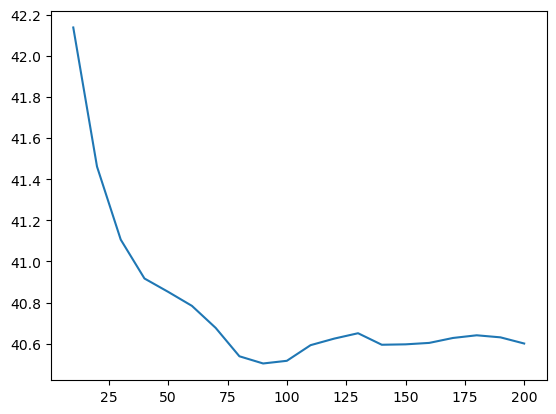

In [111]:
#plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- **80**
- 200

We can use `warm_start=True` to train faster. In this case, we train only additional 10 new trees each time, not the entire ensemble from scratch like previously

```
warm_start : bool, default=False
    When set to ``True``, reuse the solution of the previous call to fit
    and add more estimators to the ensemble, otherwise, just fit a whole
    new forest. See :term:`the Glossary <warm_start>`.
```

In [112]:
scores = []

rf = RandomForestRegressor(
    n_estimators=1,
    random_state=1,
    n_jobs=-1,
    warm_start=True,
)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

It's 7 seconds instead of 56 now

## Question 4

In [113]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(
        n_estimators=0,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

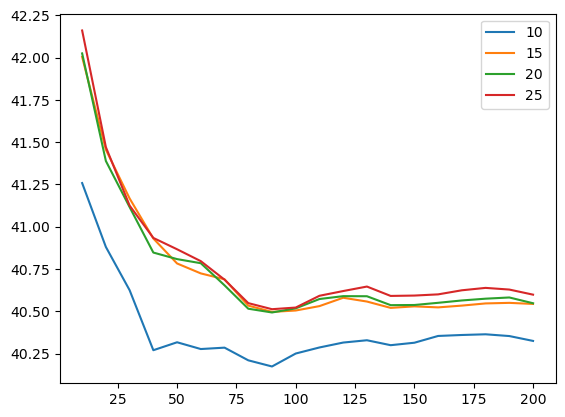

In [114]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

What's the best `max_depth`:

* **10**
* 15
* 20
* 25

Many of you had 20 as the answer, and it's pretty close, so we count **20** as the correct answer too

## Question 5

In [115]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [116]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311


What's the most important feature (among these 4)? 

* **`study_hours_per_week`**
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`


## Question 6

In [117]:
import xgboost as xgb

In [118]:
features = dv.feature_names_
features = [f.replace('<', 'less ') for f in features]
features

['access_to_learning_materials=No',
 'access_to_learning_materials=Yes',
 'age',
 'assignments_completed',
 'attendance_rate',
 'distance_to_school',
 'extra_tutorials=No',
 'extra_tutorials=Yes',
 'gender=Female',
 'gender=Male',
 'it_knowledge=High',
 'it_knowledge=Low',
 'it_knowledge=Medium',
 'parent_education_level',
 'parent_education_level=Primary',
 'parent_education_level=Secondary',
 'parent_education_level=Tertiary',
 'parent_involvement=High',
 'parent_involvement=Low',
 'parent_involvement=Medium',
 'school_location=Rural',
 'school_location=Urban',
 'school_type=Private',
 'school_type=Public',
 'socioeconomic_status=High',
 'socioeconomic_status=Low',
 'socioeconomic_status=Medium',
 'study_hours_per_week',
 'teacher_quality']

In [119]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [120]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [121]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [122]:
%%capture output_03

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [123]:
scores['eta=0.3'] = parse_xgb_output(output_03)

In [124]:
%%capture output_01

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [125]:
scores['eta=0.1'] = parse_xgb_output(output_01)

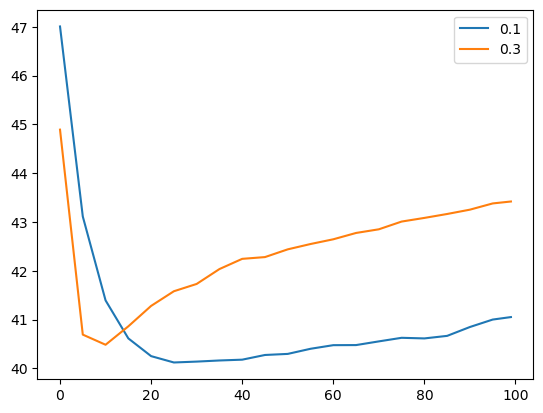

In [126]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* **0.1**
* Both give equal value

Note that rounding doesn't change the answer:

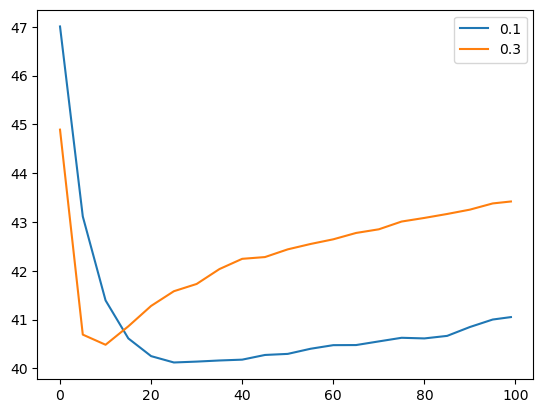

In [127]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc.round(3),
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc.round(3),
        label='0.3')
plt.legend()
plt.show()